# Plotting ((human) brain) connectivity networks
Tools like Seaborn, Nilearn, and NetworkX provide several different ways to display network connectivity data in and out of brain space.
<br><br>
Each tool's documentation includes galleries of different options for plotting, but here, I've chosen a few methods that I like to use to make figures from connectivity analyses.

In [1]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
import seaborn as sns
from nilearn import plotting

import bct

In [2]:
fig_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/figures'
data_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/data/'
roi_dir = '/Users/kbottenh/Dropbox/Data/templates/shen2015/'

masks = {'shen2015': '/Users/kbottenh/Dropbox/Projects/physics-retrieval/shen2015_2mm_268_parcellation.nii.gz', 
         'craddock2012': '/Users/kbottenh/Dropbox/Projects/physics-retrieval/craddock2012_tcorr05_2level_270_2mm.nii.gz'}

## First, I'll read in an example adjacency matrix
This is from a project I've been working on for a while, and all adjacency matrices represent pairwise correlations between BOLD signals extracted from brain regions according to a 268-node atlas. 

In [3]:
subject = 101
session = 1
task = 'fci'
condition = 'Physics'
mask = 'shen2015'
matrix = pd.read_csv(join(data_dir,
                          'output/corrmats',
                          '{0}-session-{1}_{2}-{3}_{4}-corrmat.csv'.format(subject, 
                                                                           session,
                                                                           task,
                                                                           condition, 
                                                                           mask)),
                     delimiter=' ', header=None, index_col=None)


In [4]:
matrix.head()

0         1         2         3         4         5         6    \
0  1.000000  0.507017  0.606648  0.622566  0.670695  0.621549  0.393519   
1  0.507017  1.000000  0.530534  0.490130  0.477591  0.429435  0.347303   
2  0.606648  0.530534  1.000000  0.575143  0.616934  0.490350  0.245402   
3  0.622566  0.490130  0.575143  1.000000  0.489831  0.406328  0.299695   
4  0.670695  0.477591  0.616934  0.489831  1.000000  0.674007  0.428274   

        7         8         9    ...       258       259       260       261  \
0  0.285105  0.347711  0.386857  ...  0.537537  0.427989  0.250890  0.226541   
1  0.256465  0.277979  0.239076  ...  0.478472  0.286577  0.069433  0.154846   
2  0.081818  0.190454  0.378968  ...  0.499929  0.294316  0.065828  0.125010   
3  0.287310  0.327912  0.155882  ...  0.437312  0.426774  0.066853  0.160619   
4  0.269563  0.463149  0.532759  ...  0.510540  0.228426  0.258719  0.265872   

        262       263       264       265       266       267  
0  0.479018  0.200664  0.179857  0.164712  0.248667  0.243406  
1  0.357348 -0.009553  0.208614  0.376339  0.241804  0.195128  
2  0.315452  0.261061  0.052481  0.077755  0.024709  0.033900  
3  0.452454  0.293920  0.208670  0.227970  0.104899  0.180946  
4  0.336602  0.087324  0.096158  0.110866  0.204078  0.192134  

[5 rows x 268 columns]

## And plot the adjacency matrix as a heatmap with Seaborn

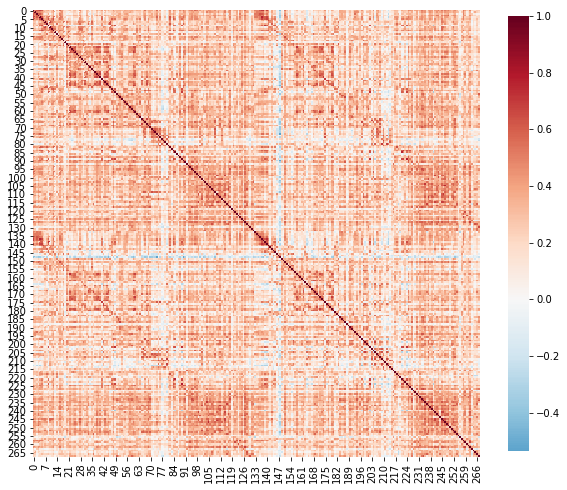

In [5]:
#pre-sort
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(matrix, square=True, center=0, cmap='RdBu_r', cbar_kws={"shrink": .8})

Seaborn also includes an option to plot a clustered heatmap, `clustermap`, which can help visualize structure in an adjacency matrix. It uses **SciPy** to perform hierarchical clustering on the data, and allows users to specify a distance metric and linkage method. These options make it a (rather lightweight) option for data-driven clustering of your data for further analyses.<br><br>
To access the reordered row indices, use:<br>
``clustergrid.dendrogram_row.reordered_ind``
<br><br>
Column indices, use:<br>
``clustergrid.dendrogram_col.reordered_ind``

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


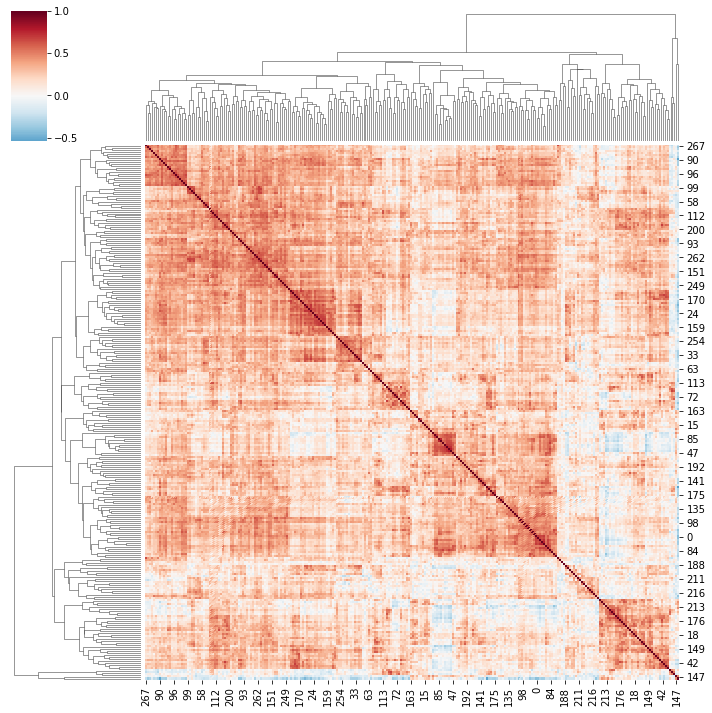

In [6]:
grid = sns.clustermap(matrix.values, cmap='RdBu_r', center=0)


## Moving into brain space...
### Here's the parcellation I used to extract regionwise BOLD signals from fMRI niftis.
Nilearn's `plot_roi` is great for plotting ROIs or parcellations like this one.

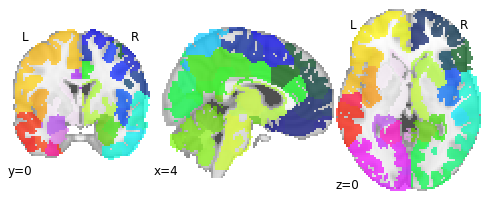

In [13]:
plotting.plot_roi(masks['shen2015'], draw_cross=False, cut_coords=[4,0,0])

### You'll need coordinates for plotting this adjacency matrix as a connectome in brain space.
Nilearn contains a million different highly useful tools for everything from extracing BOLD data from Nfitis to performing MVPA and, of course, plotting your data.<br><br>This particular tool, `find_parcellation_cut_coords`, allows the user to extract the stereotaxic coordinates of each region of their brain parcellation, which comes in handy when plotting connectivity or network data.

In [16]:
coordinates = plotting.find_parcellation_cut_coords(labels_img=masks[mask])
coordinates[:6]

array([[ 14.0832    ,  56.6944    , -16.6848    ],
       [  9.6       ,  17.61882353, -19.53411765],
       [  5.2706334 ,  35.03262956, -17.52783109],
       [ 15.64784053,  34.18604651, -22.5448505 ],
       [  8.28388747,  46.05882353,  -1.67007673],
       [ 14.58146067,  64.75280899,   3.68258427]])

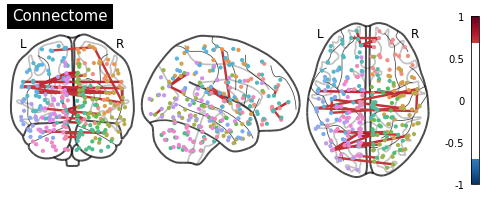

In [33]:
husl_pal = sns.husl_palette(h=0, n_colors=268, l=0.7, s=0.8)
node_size = 10
#optional: tie to fig and despine
#fig,ax = plt.subplots(figsize=(10,10))
#sns.despine(fig=fig, left=True, bottom=True)
#play with thresholding
q = plotting.plot_connectome(matrix, coordinates, 
                             node_size=node_size, node_color=husl_pal,
                             edge_threshold=.7, edge_vmax=1,
                             edge_cmap='RdBu_r',colorbar=True, 
                             title='Connectome', display_mode='ortho')

In [35]:
q.savefig('/Users/kbottenh/Desktop/connectome.png', dpi=300)

Nilearn also has a built-in function, `plot_connectome_strength`, that does just that! Allows you to visualize the strength (for weighted networks, degree for binary) of the nodes in your network. Helpful if you're interested in the properties of nodes in addition to the individual edges.

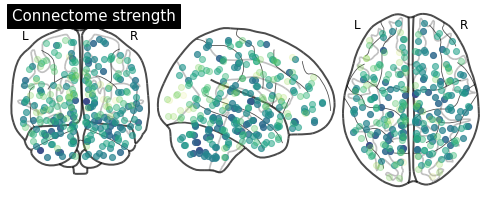

In [36]:
plotting.plot_connectome_strength(matrix, coordinates, title='Connectome strength')

And if your network includes positive and negative edge weights, you can separate this strength map into positive and negative strengths.

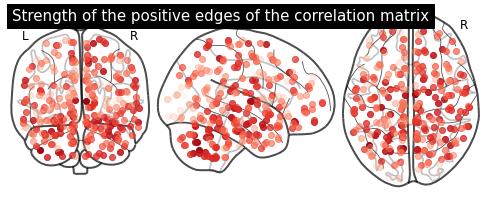

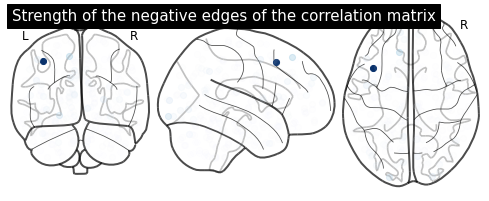

In [37]:
plotting.plot_connectome_strength(
    np.clip(matrix.values, 0, matrix.max()), coordinates, cmap='Reds',
    title='Strength of the positive edges of the correlation matrix')

plotting.plot_connectome_strength(
    np.clip(matrix.values, matrix.min(), 0), coordinates, cmap='Blues',
    title='Strength of the negative edges of the correlation matrix')

These extracted coordinates can come in handy, too, if you wanted to add some anatomical information to a heatmap.

In [38]:
for i in matrix.index:
    matrix.at[i, 'x'] = coordinates[i][0]
    matrix.at[i, 'y'] = coordinates[i][1]
    matrix.at[i, 'z'] = coordinates[i][2]
matrix.set_index([matrix.index, 'x', 'y', 'z'], inplace=True)

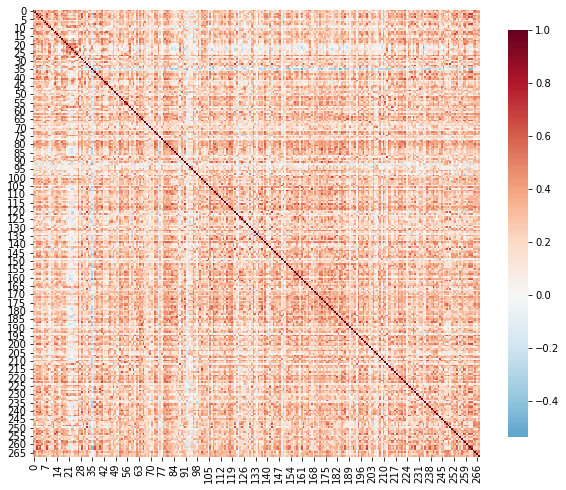

In [39]:
#sorted square heatmap based on anatomical location of nodes
matrix.index.rename(['idx', 'x', 'y', 'z'], inplace=True)
matrix.columns = matrix.index
matrix.sort_index(axis=0, level='x', ascending=True, inplace=True)
matrix.sort_index(axis=1, level='x', ascending=True, inplace=True)
nodes = list(matrix.index.get_level_values('idx').astype(int))

sns.axes_style("white")
fig, ax = plt.subplots(figsize=(10,10))
g = sns.heatmap(matrix[nodes].values, square=True, center=0, cmap='RdBu_r', cbar_kws={"shrink": .75})

#fig.savefig(join(fig_dir, '{0}-heatmap.png'.format(regression)), dpi=300)
#plt.close()

## Back to plotting in brain space
### In addition to static connectomes, Nilearn has tools for creating interactive plots
These are especially helpful for visualizing connectome data that can get pretty messy if you have a lot of nodes.

In [40]:
plotting.view_markers(coordinates, marker_size=5, marker_color=husl_pal)

In [43]:
#adjust threshodling to make a pretty map
thresh_mat = bct.threshold_proportional(matrix[nodes].values, 0.1)

coordinates = plotting.find_parcellation_cut_coords(labels_img=masks['shen2015'])
plotting.view_connectome(thresh_mat, coordinates, edge_threshold='99%', edge_cmap='RdBu_r')

## Moving beyond brain space to network space
Nilearn is great for visualizing brain networks in the brain, but to visualize them with spatially-embedded network properties, we'll use NetworkX.

In [45]:
thresh_mat = bct.threshold_proportional(matrix[nodes].values, 0.1)
G = nx.convert_matrix.from_numpy_array(thresh_mat)

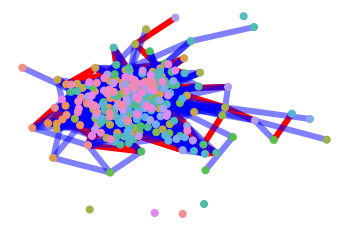

In [48]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, k=0.2, scale=100)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=husl_pal)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6, edge_color="r")
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b")

plt.axis("off")
plt.show()

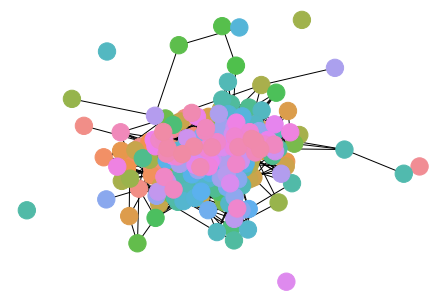

In [49]:
pos = nx.spring_layout(G, k=0.2)
options = {
    "node_color": husl_pal,
    "width": 1,
    "edge_cmap": plt.cm.RdBu_r,
    "with_labels": False,
}
nx.draw(G, pos, **options)
plt.show()

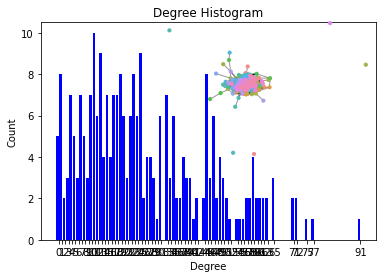

In [50]:
import collections

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(G)
plt.axis("off")
options = {
    "node_color": husl_pal,
}
nx.draw_networkx_nodes(G, pos, node_size=10, **options)
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_cmap=plt.cm.RdBu_r)
plt.show()